Code released on GitHub with the lecture "Analysis of e-phys data" during the neuroscience track core course at IST Austria. https://github.com/michnard/SpikeSortingTutorial

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd

## Step 1: load position

In our simulations, the position is recorded every 1ms. The track is 100cm long, and the animal travels back and forth on this track.

In [2]:
locs = np.load('locs.npy',allow_pickle=True) #1D locations - 1ms time resolution

Text(0.5, 0, 'Time (ms)')

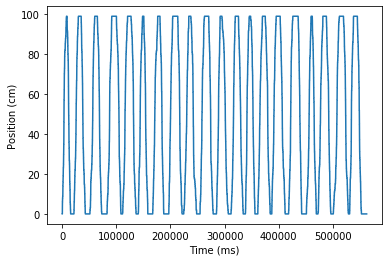

In [3]:
plt.plot(locs)
plt.ylabel('Position (cm)')
plt.xlabel('Time (ms)')

## Step 2: load cell activity (the ones we clustered before!)

Here we want to load the spiking data and make sure that they are in a manageable format.

To do that, we will bin the data: that is, for each cell, we will count the number of spikes emitted in nonoverlapping time windows.

In [4]:
res,clu = np.load('clus_res.npy',allow_pickle=True)

In [71]:
N = np.max(clu)+1 # number of cells

# bin data in 250ms time bins
bindata = np.zeros([N, int(len(locs)/250)+1])
for r,c in np.vstack([res,clu]).T:
    bindata[c][int(r/5000)] += 1

Text(0, 0.5, 'Cell')

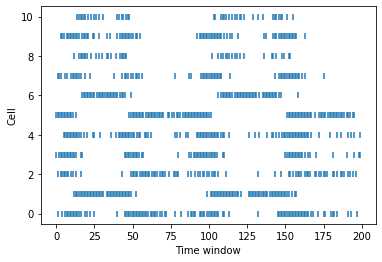

In [78]:
# look at the first 200 time windows
plt.scatter(np.where(bindata[:,:200])[1],np.where(bindata[:,:200])[0],marker='|')
plt.xlabel('Time window')
plt.ylabel('Cell')

In [36]:
# downsample location too -> aligned to the time windows used for binning
loc_down = locs[np.arange(len(bindata[0]))*250]

## Step 3: create firing rate maps

We want to measure, for each cell, how likely it is to fire at each location on the track.

To do that, we will go through our data, and measure the average firing rate of each cell for each location.

Afterwards, we will apply some smoothing to regularize.

Note / exercise: the last step enforces smoothness on the inferred firing rate maps. The best way of choosing the amount of smoothing would be by cross validation. To do that, you would need to split the data in two chuncks (like 75% - 25%), infer firing rate maps on one set and validate on the other. Can you implement that, assuming that cells have Poisson firing rate?

In [37]:
frm = np.zeros([N,100])

for i in range(N): # for each cell
    for lo in range(100): # for each location [0-100]
        frm[i,lo] = np.mean(bindata[i][loc_down == lo])
    
    # apply some smoothing
    frm[i] = nd.gaussian_filter1d(frm[i],3)

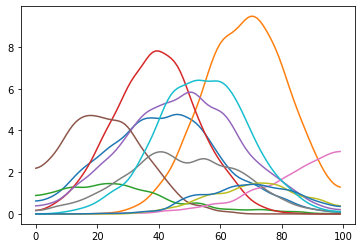

In [39]:
plt.plot(frm.T)
plt.show()

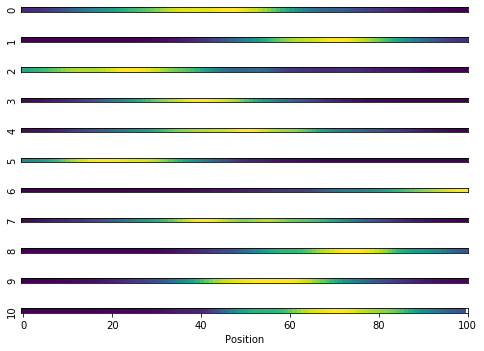

In [40]:
plt.figure(figsize=(8,6))
for i in range(11):
    plt.subplot(11,1,i+1)
    plt.imshow(frm[i].reshape(1,-1))#,vmin=0,vmax=9)
    plt.yticks([])
    plt.xticks([])
    plt.ylabel(str(i))
    if i == 10:
        plt.xticks(np.arange(6)*20)
        plt.xlabel('Position')

## Step 4: use data to decode the position

Option 1: use simple population vector decoder. 

Denote with $pv(l)$ the vector of average activity of each cell at location $l$.
Given population activity $x = (x_1, ..., x_N)$, the decoded location is
$$dec = arg\max_l sim(pv(l), x)$$
where $sim$ is a similarity measure (like a correlation coefficient, or cosine similarity).

In [60]:
def corr(x,pvs): # here we'll use a simple correlation between activation and population vectors
    zx = (x - np.mean(x))/np.std(x)
    zpvs = (pvs - np.mean(pvs,0))/np.std(pvs,0)
    return zx @ zpvs

In [61]:
loc_dec = []

for b in bindata.T:
    if np.sum(b) == 0: # in this case there are no spikes -> no info
        loc_dec.append(np.nan) 
    else:
        loc_dec.append(np.argmax(corr(b,frm)))
loc_dec = np.array(loc_dec)

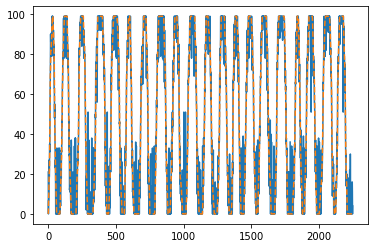

In [65]:
plt.plot(loc_dec)
plt.plot(loc_down,linestyle='dashed')

In [66]:
# average error of our decoder
np.nanmean(np.abs(loc_down - loc_dec))

5.4423076923076925

Option 2: use a bayesian decoder.

Knowing that each cell follows a Poisson statistic, we can recover the most likely position that triggered response $x$ by applying bayes rule:

$$P(l | x) \propto P(x | l) P(l)$$

In particular, if we have that cell $i$ fires $\lambda_i(l)$ spikes on average at position $l$, then

$$P(x_i = k | l) = \frac{e^{-\lambda_i(l)} \lambda_i(l)^k}{k!}$$

Assuming that the cells are independent of each other, we also have

$$P(x | l) = \prod_{i=1}^N p(x_i | l)$$

In [44]:
from scipy.special import factorial
def bayes_likelihood(b,frm):
    return np.prod(np.exp(-frm.T)*frm.T**b / factorial(b),1)

In [45]:
loc_dec_bay = []

for b in bindata.T:
    if np.sum(b) == 0: # if there are no spikes, I have no information -> exclude those
        loc_dec_bay.append(np.nan)
    else:
        loc_dec_bay.append(np.argmax(bayes_likelihood(b,frm)))
loc_dec_bay = np.array(loc_dec_bay)

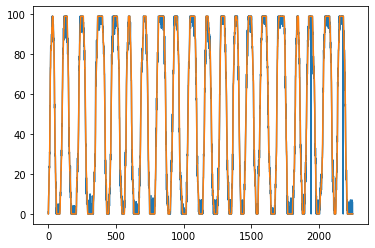

In [46]:
plt.plot(loc_dec_bay)
plt.plot(loc_down)

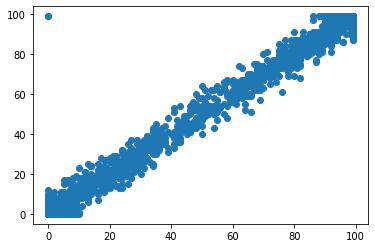

In [70]:
plt.scatter(loc_dec_bay, loc_down)

In [67]:
# average error of bayesian decoder
np.nanmean(np.abs(loc_down - loc_dec_bay))

2.487477638640429